In [158]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

In [202]:

def generate_data(X, what='y', extra=None, error_scale=5):
    '''
    function for generating y data given an x matrix.
    does y = X1 + X2 + ... + Xn + normal(0, stdev=error+scale)
    can also randomly sample, or return mean/quantiles of the distribution
    '''
    from scipy.stats import norm
    if what=='y':
        return(X.sum(axis=1) + np.random.normal(scale=error_scale, size=X.shape[0]))
    if what=='mean':
        return(X.sum(axis=1))
    if what=='quantile':
        return(X.sum(axis=1) + norm.ppf(extra) * error_scale)
    else:
        raise ValueError

In [203]:
# fake data
n = 10000
d = 5
train_cutoff = int(.5*n)
X = np.random.normal(size=(n,d))
y = generate_data(X,'y')
X_test = np.random.normal(size=(n//5,d))

In [204]:
# seems to be correct check the data gen function makes sense
print(y[:5])
print(generate_data(X[:5,:],'y'))
print(generate_data(X[:5,:],'mean'))
print(generate_data(X[:5,:],'quantile', .5))
print(generate_data(X[:5,:],'quantile', .95))
print(generate_data(X[:5,:],'quantile', .05))

[-3.21002246  1.69763932 -0.29241383  2.73133889 -2.98678299]
[-2.7564727   4.99570661 -8.20127571  2.95258721  1.85840915]
[ 2.14036438  0.86572829 -1.35550121  0.80392405 -1.41587682]
[ 2.14036438  0.86572829 -1.35550121  0.80392405 -1.41587682]
[ 10.36463252   9.08999642   6.86876692   9.02819218   6.80839131]
[-6.08390375 -7.35853984 -9.57976935 -7.42034409 -9.64014495]


In [205]:
# generate train/test dmatrices
dat_train = lgb.Dataset(X[:train_cutoff,:], label=y[:train_cutoff])
dat_val = lgb.Dataset(X[train_cutoff:,:], label=y[train_cutoff:])

In [225]:
# ok now let's do some quantile regression
params = {
    'objective':'quantile',
    'alpha':.75,
    'learning_rate':.01,
    'num_leaves':31,
    'max_depth':2,
    'lambda_l2':10,
    'lambda_l1':10,
    'min_data_in_leaf':10,
    'min_split_gain':0,
    'bagging_fraction':.8,
    'bagging_freq':1,
    'feature_fraction':.8,
}
model_75 = lgb.train(params=params, train_set=dat_train, valid_sets=[dat_val],
                        num_boost_round=5000, early_stopping_rounds=20, verbose_eval=100)
params['alpha'] = .25
model_25 = lgb.train(params=params, train_set=dat_train, valid_sets=[dat_val], 
                        num_boost_round=5000, early_stopping_rounds=20, verbose_eval=100)

Training until validation scores don't improve for 20 rounds.
[100]	valid_0's quantile: 1.71555
[200]	valid_0's quantile: 1.6762
[300]	valid_0's quantile: 1.65242
[400]	valid_0's quantile: 1.63674
[500]	valid_0's quantile: 1.62766
[600]	valid_0's quantile: 1.62081
[700]	valid_0's quantile: 1.617
[800]	valid_0's quantile: 1.61474
[900]	valid_0's quantile: 1.61406
[1000]	valid_0's quantile: 1.61366
Early stopping, best iteration is:
[1047]	valid_0's quantile: 1.61344
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's quantile: 1.70728
[200]	valid_0's quantile: 1.67254
[300]	valid_0's quantile: 1.65197
[400]	valid_0's quantile: 1.63966
[500]	valid_0's quantile: 1.63182
[600]	valid_0's quantile: 1.62741
[700]	valid_0's quantile: 1.62469
[800]	valid_0's quantile: 1.62325
[900]	valid_0's quantile: 1.62277
Early stopping, best iteration is:
[918]	valid_0's quantile: 1.62277


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


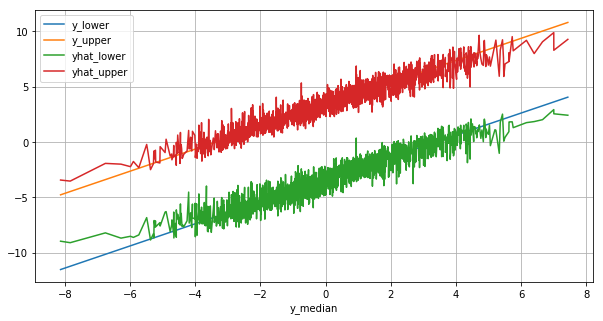

In [226]:
# generate real quantiles on test data, also generate estimated quantiles and plot. to compare them.
# the plot has x-axis the median value of y, and the y-values are the real/predicted quartiles
df = pd.DataFrame({
    'y_lower': generate_data(X_test,'quantile', .25),
    'y_median': generate_data(X_test,'quantile', .5),
    'y_upper': generate_data(X_test,'quantile', .75),
    'yhat_upper': model_75.predict(X_test),
    'yhat_lower': model_25.predict(X_test)
})
df.sort_values('y_median').plot(x='y_median', y=['y_lower', 'y_upper', 'yhat_lower', 'yhat_upper'], figsize=(10,5),grid=True)
# quantiles are fairly noisy, but seem concentrated around the truth

In [286]:
# now try distributional regression
def distify(X, y, copies_per_observation=10):
    '''
    takes an input array, turns it into something for distributional regression by randomly
    sampling copies_per_observation values and then assigning a 1 or 0 depending on if the quantity 
    is more/less than the actual y value.
    we'll uniformly sample between min and max y, even though that's a bit non-kosher (ideally should specify this ex ante)
    '''
    X2 = np.tile(X,(copies_per_observation,1))
    y2 = np.tile(y,(copies_per_observation))
    comparison_col = np.random.uniform(y.min(), y.max(), size=(X2.shape[0],1))
    new_y = (comparison_col[:,0]>y2).astype(int)
    # generate your new x column
    new_X = np.concatenate([X2,comparison_col], axis=1)
    return(new_X, new_y)

In [293]:
new_X_train, new_y_train = distify(X[:train_cutoff,:], y[:train_cutoff])
new_X_val, new_y_val = distify(X[train_cutoff:,:], y[train_cutoff:])

In [294]:
# new dmatrices for this
new_dat_train = lgb.Dataset(new_X_train, label=new_y_train)
new_dat_val = lgb.Dataset(new_X_val, label=new_y_val)

In [347]:
# params and train
params = {
    'objective':'binary',
    'learning_rate':.01,
    'num_leaves':31,
    'max_depth':2,
    'lambda_l2':1,
    'lambda_l1':.1,
    'min_data_in_leaf':10,
    'min_split_gain':1,
    'bagging_fraction':.3,
    'bagging_freq':1,
    'feature_fraction':.3,
    'monotone_constraint':(0,0,0,0,0,1),
}
model_dist = lgb.train(params=params, train_set=new_dat_train, valid_sets=[new_dat_val],
                        num_boost_round=5000, early_stopping_rounds=20, verbose_eval=100)

Training until validation scores don't improve for 20 rounds.
[100]	valid_0's binary_logloss: 0.610376
[200]	valid_0's binary_logloss: 0.567104
[300]	valid_0's binary_logloss: 0.50124
[400]	valid_0's binary_logloss: 0.453389
[500]	valid_0's binary_logloss: 0.413514
[600]	valid_0's binary_logloss: 0.381941
[700]	valid_0's binary_logloss: 0.356699
[800]	valid_0's binary_logloss: 0.336491
[900]	valid_0's binary_logloss: 0.315234
[1000]	valid_0's binary_logloss: 0.304676
[1100]	valid_0's binary_logloss: 0.29735
[1200]	valid_0's binary_logloss: 0.291483
[1300]	valid_0's binary_logloss: 0.282722
[1400]	valid_0's binary_logloss: 0.275226
[1500]	valid_0's binary_logloss: 0.268083
[1600]	valid_0's binary_logloss: 0.263292
[1700]	valid_0's binary_logloss: 0.260159
[1800]	valid_0's binary_logloss: 0.256703
[1900]	valid_0's binary_logloss: 0.254518
[2000]	valid_0's binary_logloss: 0.252222
[2100]	valid_0's binary_logloss: 0.250125
[2200]	valid_0's binary_logloss: 0.248535
[2300]	valid_0's binary_l

In [348]:
lgb.__version__

'2.1.1'

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


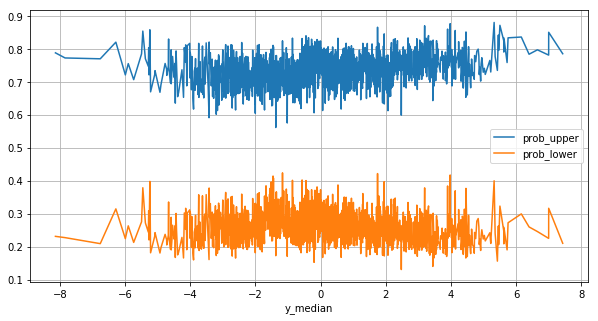

In [346]:
# generate some predicted values for the 75 and 25 quantiles
df2 = pd.DataFrame({
    'y_lower': generate_data(X_test,'quantile', .25),
    'y_median': generate_data(X_test,'quantile', .5),
    'y_upper': generate_data(X_test,'quantile', .75),
})
df2['prob_lower'] = model_dist.predict(np.concatenate([X_test,df2[['y_lower']].values], axis=1))
df2['prob_upper'] = model_dist.predict(np.concatenate([X_test,df2[['y_upper']].values], axis=1))

df2.sort_values('y_median').plot(x='y_median', y=['prob_upper', 'prob_lower'], figsize=(10,5),grid=True)
# seems to work; the predicted probabilities for the 25/75 quantiles are concentrated around .25/.75